In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../scripts')

In [4]:
# Load the datasets
brent_oil_data = pd.read_csv('../data/Copy of BrentOilPrices.csv')

In [5]:
brent_oil_data['Date'] = pd.to_datetime(brent_oil_data['Date'])

(        Date  Price
 0 1987-05-20  18.63
 1 1987-05-21  18.45
 2 1987-05-22  18.55
 3 1987-05-25  18.60
 4 1987-05-26  18.63,
 <Axes: title={'center': 'Brent Oil Prices Over Time'}>)

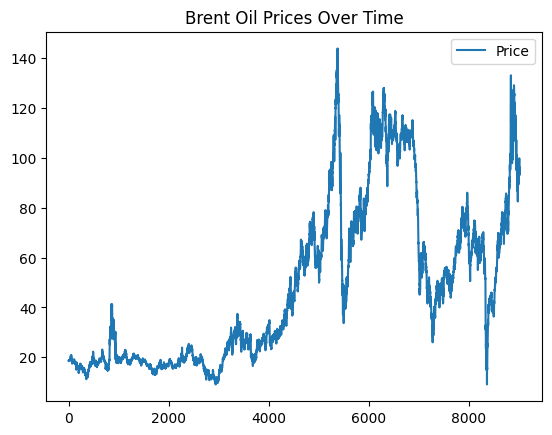

In [6]:
# Display information about missing dates if any, and plot the data
brent_oil_data.head(), brent_oil_data.plot(y='Price', title='Brent Oil Prices Over Time')

In [7]:
# Check for missing values
missing_values = brent_oil_data.isnull().sum()

In [8]:
# Drop any duplicate rows if they exist
brent_oil_data = brent_oil_data.drop_duplicates()

In [9]:
# Sort the data by date
brent_oil_data = brent_oil_data.sort_values(by='Date').reset_index(drop=True)

In [10]:
# Display basic info and missing values
print("Data Information:")
print(brent_oil_data.info())
print("\nMissing Values:\n", missing_values)


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB
None

Missing Values:
 Date     0
Price    0
dtype: int64


Descriptive Statistics for Brent Oil Prices:
count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64


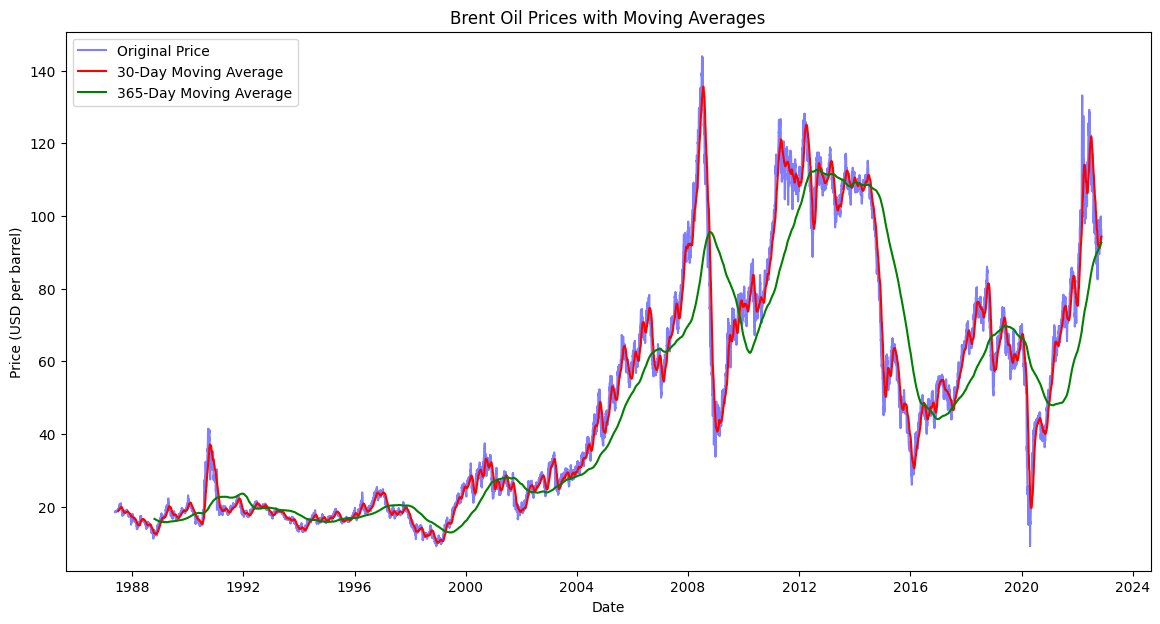


Price Volatility (Daily Return Std. Dev.): 0.0253


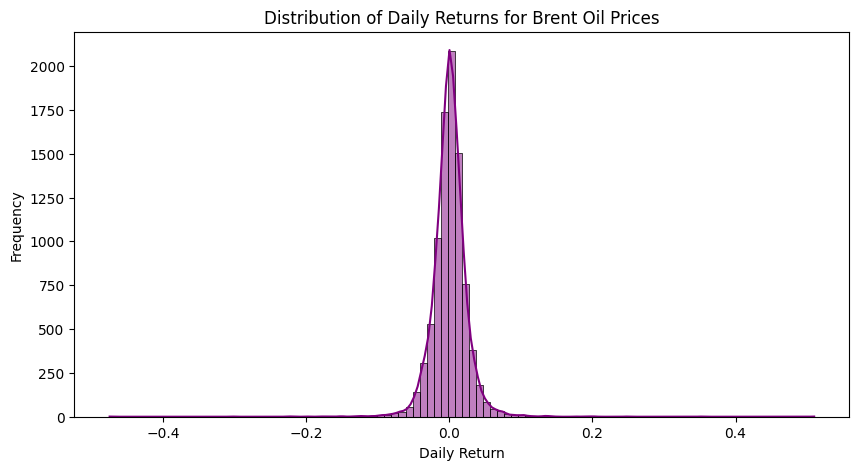


Significant Price Movements (>5% change in a day):
           Date   Price  Daily_Return
147  1987-12-14   16.80     -0.052453
150  1987-12-17   15.03     -0.056497
153  1987-12-22   16.70      0.084416
163  1988-01-08   16.88     -0.056983
289  1988-07-07   15.50      0.068966
...         ...     ...           ...
8923 2022-07-12  106.98     -0.068524
8931 2022-07-22  106.77     -0.053541
8947 2022-08-15   98.25     -0.052555
8963 2022-09-07   86.83     -0.050312
8974 2022-09-23   84.29     -0.067588

[354 rows x 3 columns]


In [11]:
# Descriptive statistics
print("Descriptive Statistics for Brent Oil Prices:")
print(brent_oil_data['Price'].describe())

# Moving Average to visualize trends (using 30-day and 365-day windows for monthly and yearly trends)
brent_oil_data['Price_MA_30'] = brent_oil_data['Price'].rolling(window=30).mean()
brent_oil_data['Price_MA_365'] = brent_oil_data['Price'].rolling(window=365).mean()

# Plot the original series and moving averages
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Date'], brent_oil_data['Price'], label='Original Price', color='blue', alpha=0.5)
plt.plot(brent_oil_data['Date'], brent_oil_data['Price_MA_30'], label='30-Day Moving Average', color='red')
plt.plot(brent_oil_data['Date'], brent_oil_data['Price_MA_365'], label='365-Day Moving Average', color='green')
plt.title('Brent Oil Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()

# Price Volatility: Calculate the daily return and its standard deviation (volatility)
brent_oil_data['Daily_Return'] = brent_oil_data['Price'].pct_change()  # Daily returns
volatility = brent_oil_data['Daily_Return'].std()  # Standard deviation as a measure of volatility
print(f"\nPrice Volatility (Daily Return Std. Dev.): {volatility:.4f}")

# Plot histogram of daily returns to visualize volatility distribution
plt.figure(figsize=(10, 5))
sns.histplot(brent_oil_data['Daily_Return'].dropna(), bins=100, kde=True, color='purple')
plt.title('Distribution of Daily Returns for Brent Oil Prices')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

# Detecting large price movements: filtering for days with large price changes
# Set a threshold for significant daily changes (e.g., more than 5% change)
significant_changes = brent_oil_data[brent_oil_data['Daily_Return'].abs() > 0.05]
print("\nSignificant Price Movements (>5% change in a day):")
print(significant_changes[['Date', 'Price', 'Daily_Return']])


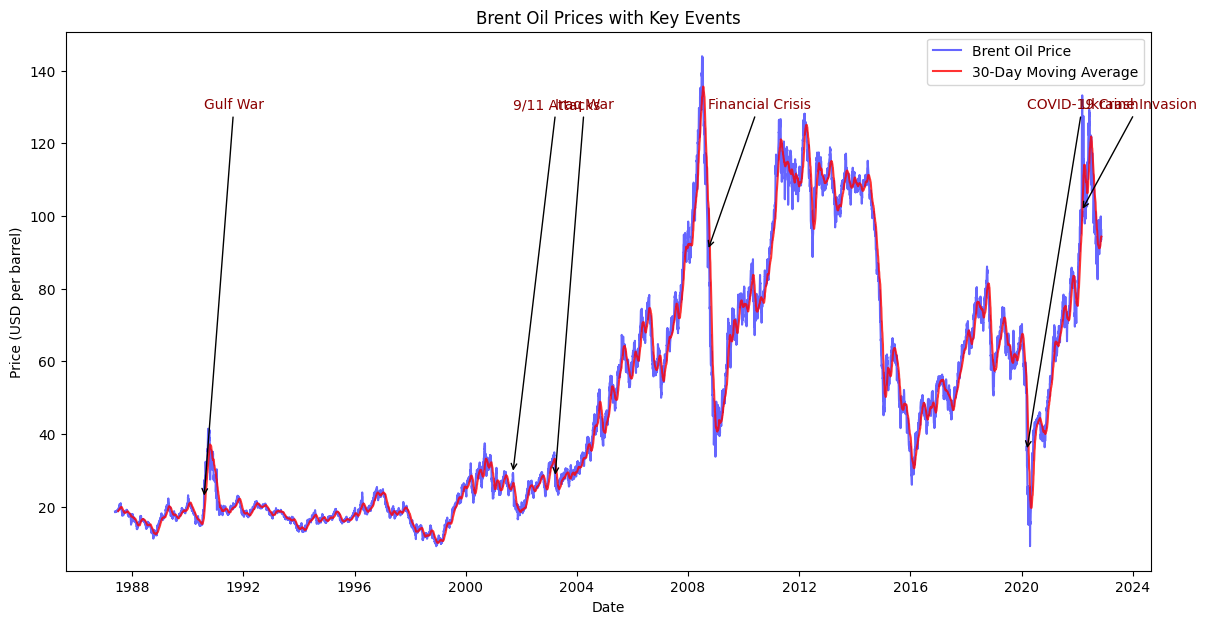

In [13]:
# a DataFrame with key events
key_events = pd.DataFrame({
    'Date': pd.to_datetime([
        '1990-08-02',  # Gulf War starts
        '2001-09-11',  # 9/11 attacks
        '2003-03-20',  # Iraq War
        '2008-09-15',  # Global Financial Crisis
        '2014-06-01',  # Oil price collapse due to oversupply
        '2020-03-09',  # Oil price crash due to COVID-19 pandemic
        '2022-02-24'   # Russian invasion of Ukraine
    ]),
    'Event': [
        'Gulf War',
        '9/11 Attacks',
        'Iraq War',
        'Financial Crisis',
        'Oil Price Collapse',
        'COVID-19 Crash',
        'Ukraine Invasion'
    ]
})

# Step 2: Merge events with the Brent oil data (on date)
brent_oil_data = pd.merge(brent_oil_data, key_events, on='Date', how='left')

# Step 3: Plot Brent oil prices with event annotations
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Date'], brent_oil_data['Price'], label='Brent Oil Price', color='blue', alpha=0.6)
plt.plot(brent_oil_data['Date'], brent_oil_data['Price_MA_30'], label='30-Day Moving Average', color='red', alpha=0.8)

# Annotate key events on the plot
for idx, row in key_events.iterrows():
    # Check if the date exists in brent_oil_data
    price_values = brent_oil_data.loc[brent_oil_data['Date'] == row['Date'], 'Price'].values
    if len(price_values) > 0:
        plt.annotate(row['Event'],
                     xy=(row['Date'], price_values[0]),
                     xytext=(row['Date'], brent_oil_data['Price'].max() * 0.9),
                     arrowprops=dict(arrowstyle='->', color='black'),
                     fontsize=10, color='darkred')


plt.title('Brent Oil Prices with Key Events')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.show()


### ARIMA MODEL

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287
The time series is not stationary.
ADF Statistic: -15.52936758004806
p-value: 2.2307405105160745e-28
The time series is stationary.


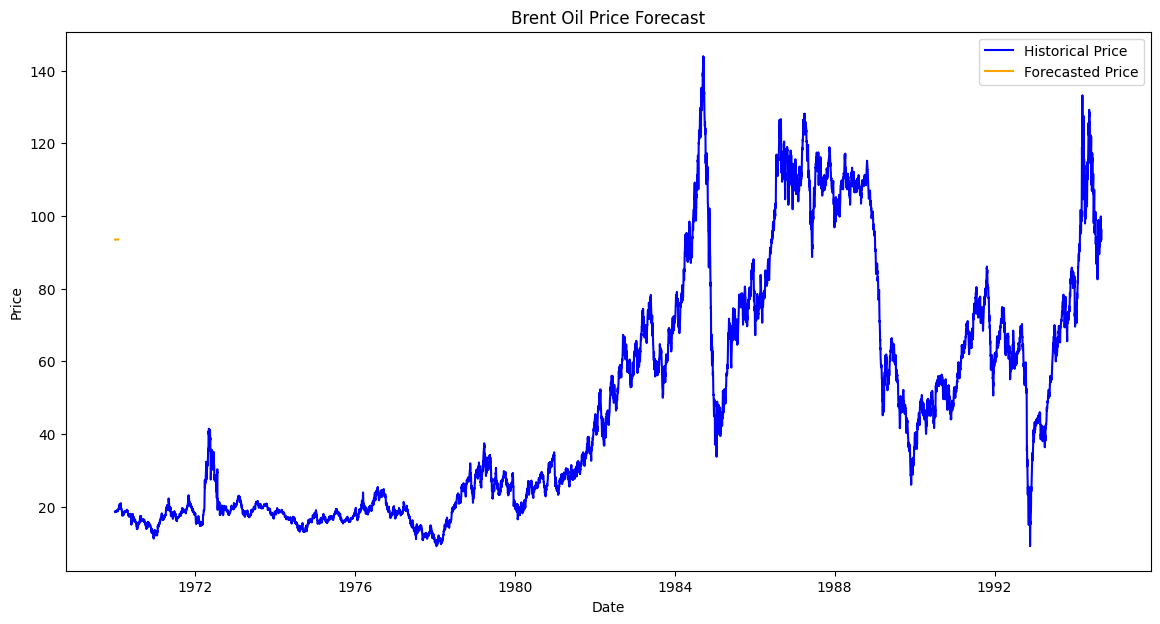

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Check stationarity with ADF test
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print('The time series is stationary.')
    else:
        print('The time series is not stationary.')

test_stationarity(brent_oil_data['Price'])

# Differencing if necessary (to achieve stationarity)
brent_oil_data['Price_diff'] = brent_oil_data['Price'].diff().dropna()
test_stationarity(brent_oil_data['Price_diff'].dropna())

# Fit the ARIMA model (choose parameters p, d, q based on ACF and PACF plots)
model = sm.tsa.ARIMA(brent_oil_data['Price'], order=(1, 1, 1))  # Example parameters
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=30)  # Forecasting the next 30 days

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data['Price'], label='Historical Price', color='blue')
plt.plot(pd.date_range(start=brent_oil_data.index[-1], periods=31, freq='D')[1:], forecast, label='Forecasted Price', color='orange')
plt.title('Brent Oil Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### GARCH MODEL

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3874927804.158277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 70148.68734205695
Iteration:      3,   Func. Count:     19,   Neg. LLF: 924509187.1107914
Iteration:      4,   Func. Count:     27,   Neg. LLF: 44099.26204018903
Iteration:      5,   Func. Count:     33,   Neg. LLF: 41882.581755042986
Iteration:      6,   Func. Count:     39,   Neg. LLF: 41190.23335963133
Iteration:      7,   Func. Count:     46,   Neg. LLF: 40221.97253756566
Iteration:      8,   Func. Count:     52,   Neg. LLF: 38675.84139852016
Iteration:      9,   Func. Count:     58,   Neg. LLF: 46507.19984815386
Iteration:     10,   Func. Count:     64,   Neg. LLF: 52311.49939565074
Iteration:     11,   Func. Count:     73,   Neg. LLF: 39566.28900289833
Iteration:     12,   Func. Count:     79,   Neg. LLF: 37683.04414723057
Iteration:     13,   Func. Count:     85,   Neg. LLF: 38550.85348090723
Iteration:     14,   Func. Count:     91,   Neg. LLF: 48052.343

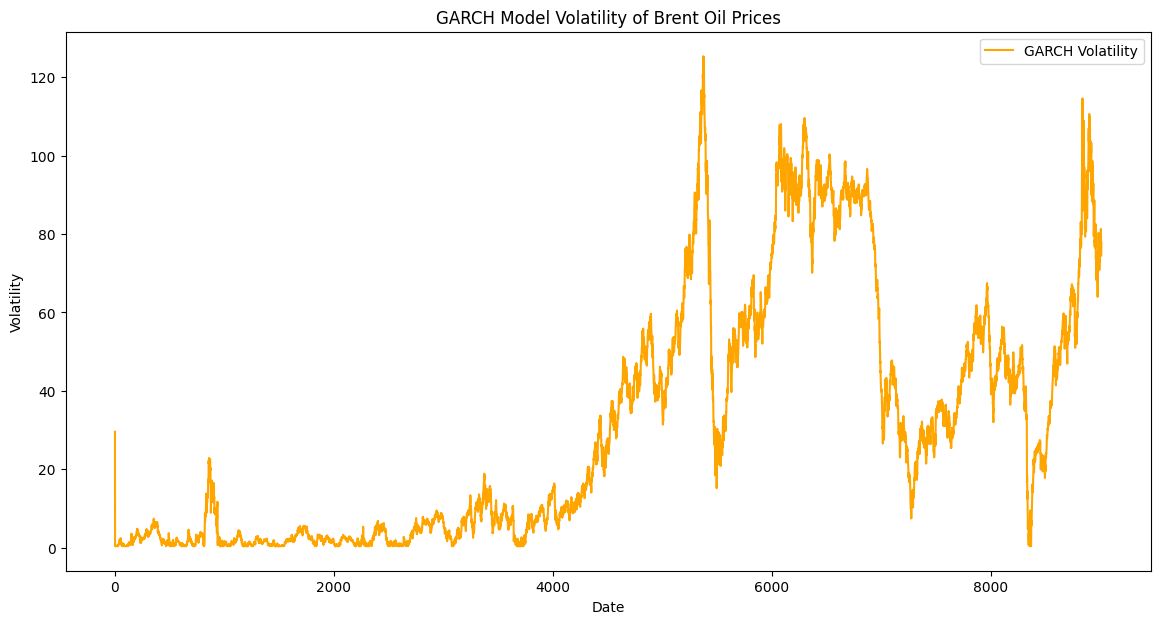

In [15]:
from arch import arch_model

# Fit a GARCH model
garch_model = arch_model(brent_oil_data['Price'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()

# Display the model summary
print(garch_fit.summary())

# Plot volatility
plt.figure(figsize=(14, 7))
plt.plot(garch_fit.conditional_volatility, label='GARCH Volatility', color='orange')
plt.title('GARCH Model Volatility of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Markov-Switching ARIMA MODEL

                        Markov Switching Model Results                        
Dep. Variable:                  Price   No. Observations:                 9011
Model:               MarkovRegression   Log Likelihood              -35281.967
Date:                Mon, 04 Nov 2024   AIC                          70575.934
Time:                        11:55:44   BIC                          70618.571
Sample:                             0   HQIC                         70590.441
                               - 9011                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0441      0.088    227.669      0.000      19.872      20.217
sigma2        26.3180      0.704     37.394      0.0

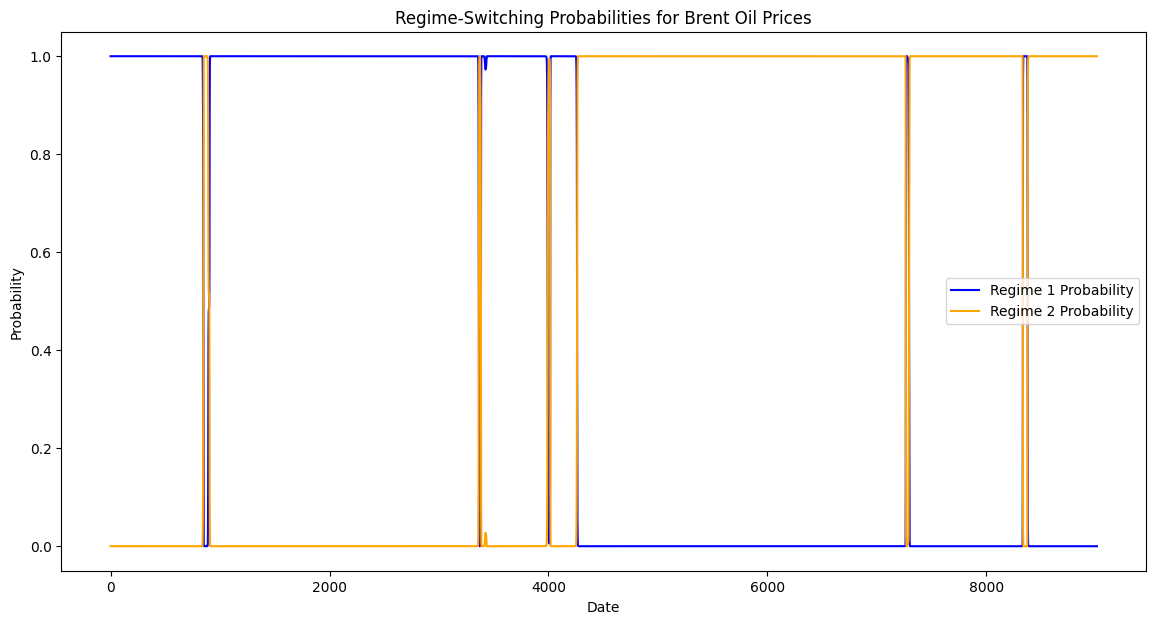

In [19]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit a Markov-Switching model
ms_model = MarkovRegression(brent_oil_data['Price'], k_regimes=2, trend='c', switching_variance=True)
ms_fit = ms_model.fit()

# Print model summary
print(ms_fit.summary())

# Plot the smoothed probabilities of each regime
plt.figure(figsize=(14, 7))
plt.plot(ms_fit.smoothed_marginal_probabilities[0], label='Regime 1 Probability', color='blue')
plt.plot(ms_fit.smoothed_marginal_probabilities[1], label='Regime 2 Probability', color='orange')
plt.title('Regime-Switching Probabilities for Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.show()


### LSTM MODEL

Epoch [10/50], Loss: 0.0002
Epoch [20/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0002
Epoch [50/50], Loss: 0.0005


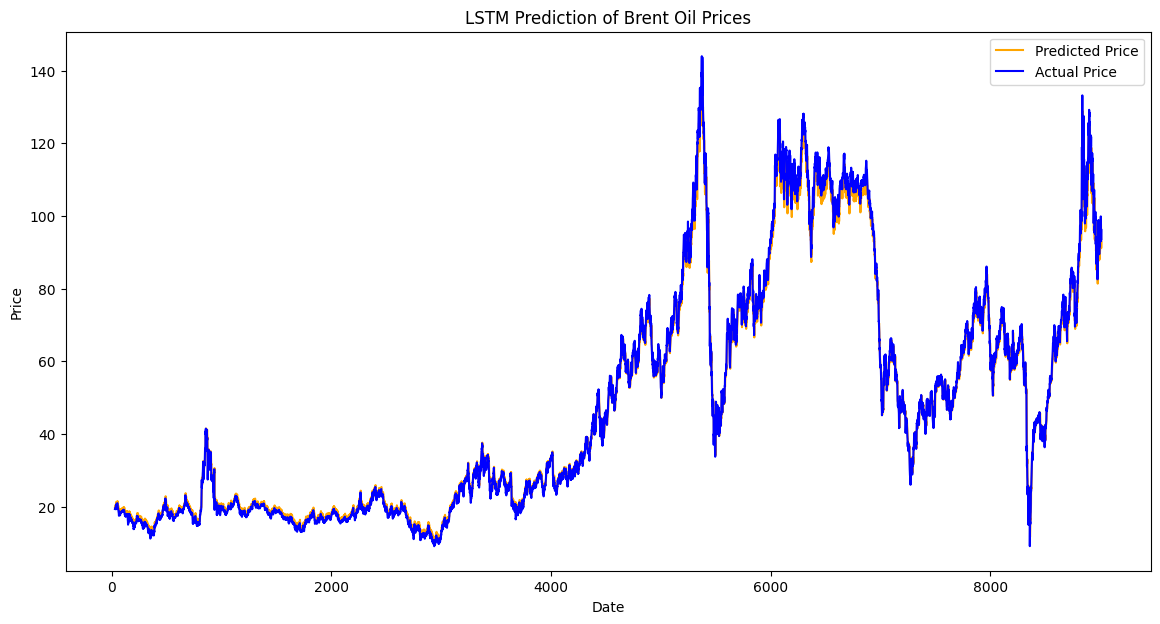

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for LSTM
data = brent_oil_data['Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, time_step=30)

# Convert to PyTorch tensors
X = torch.FloatTensor(X).unsqueeze(-1)
y = torch.FloatTensor(y)

# Create PyTorch Dataset and DataLoader
class OilPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OilPriceDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Initialize model, loss function, and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model.eval()
with torch.no_grad():
    predicted = model(X).numpy()

# Inverse transform predictions
predicted_price = scaler.inverse_transform(predicted)

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_data.index[-len(predicted_price):], predicted_price, label='Predicted Price', color='orange')
plt.plot(brent_oil_data['Price'][-len(predicted_price):], label='Actual Price', color='blue')
plt.title('LSTM Prediction of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Prophet MODEL

13:49:41 - cmdstanpy - INFO - Chain [1] start processing
13:49:52 - cmdstanpy - INFO - Chain [1] done processing


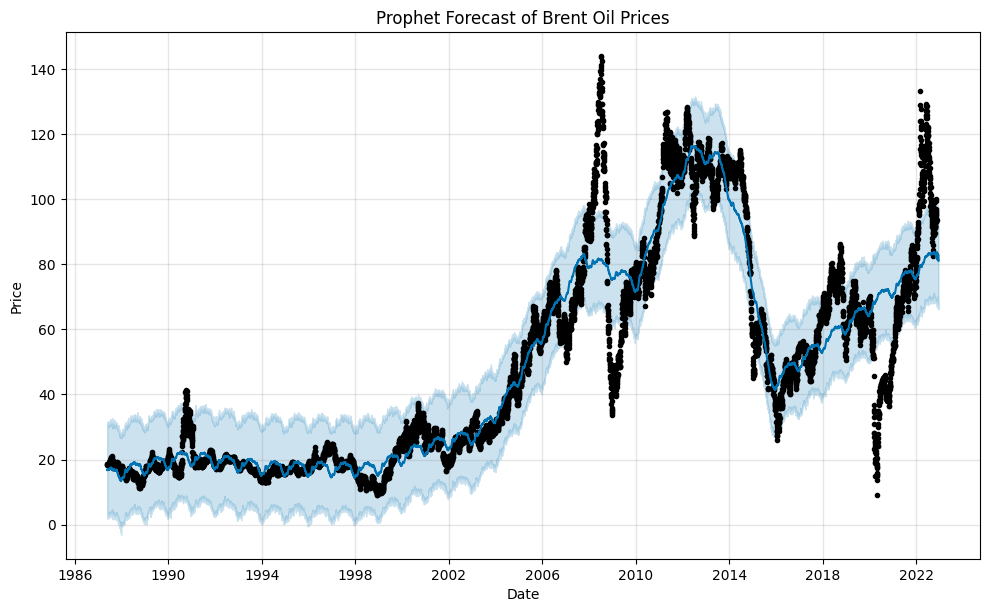

In [29]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet
prophet_data = brent_oil_data.reset_index()
prophet_data = prophet_data[['Date', 'Price']]  # Select only Date and Price columns
prophet_data.columns = ['ds', 'y']  # Rename columns

# Ensure the date column is in datetime format
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

# Fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make future predictions
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title('Prophet Forecast of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [26]:
import requests
import pandas as pd
from datetime import datetime
import time
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Set up the indicators of interest with World Bank codes
indicators = {
    'NY.GDP.MKTP.CD': 'GDP',                    # GDP (current US$)
    'FP.CPI.TOTL.ZG': 'Inflation Rate',         # Inflation, consumer prices (annual %)
    'SL.UEM.TOTL.ZS': 'Unemployment Rate',      # Unemployment, total (% of total labor force)
    'FR.INR.RINR': 'Real Interest Rate',        # Real interest rate (%)
    'NE.TRD.GNFS.ZS': 'Trade Balance',          # Trade (% of GDP)
    'PA.NUS.FCRF': 'Currency Exchange Rate'     # Official exchange rate (LCU per US$, period average)
}

# List of G20 countries (excluding the EU)
g20_countries = ['USA', 'CHN', 'JPN', 'DEU', 'GBR', 'FRA', 'ITA', 'CAN', 'BRA', 'RUS', 'IND', 'AUS', 'KOR', 'MEX', 'IDN', 'TUR', 'SAU', 'ZAF', 'ARG']

def get_wb_data(country, indicator):
    base_url = "http://api.worldbank.org/v2/country/{}/indicator/{}?format=json&per_page=1000&date=1987:2022"
    
    session = requests.Session()
    retry = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    try:
        response = session.get(base_url.format(country, indicator))
        response.raise_for_status()
        data = response.json()[1]
        return pd.DataFrame(data)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {country}, {indicator}: {e}")
        return pd.DataFrame()

# Fetch data for all countries and indicators
all_data = []
for country in g20_countries:
    for indicator_code, indicator_name in indicators.items():
        df = get_wb_data(country, indicator_code)
        if not df.empty:
            df['country'] = country
            df['indicator'] = indicator_name
            all_data.append(df)
        time.sleep(1)  # Add a delay to avoid overwhelming the API

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Pivot the data to create a wide format
pivot_data = combined_data.pivot_table(values='value', index=['country', 'date'], columns='indicator')
pivot_data.reset_index(inplace=True)

# Convert 'date' to datetime
pivot_data['date'] = pd.to_datetime(pivot_data['date'])

# Sort the data
pivot_data.sort_values(['country', 'date'], inplace=True)

# Save the data to a CSV file
pivot_data.to_csv('../data/global_economic_indicators.csv', index=False)

# Display the first few rows of the DataFrame
print(pivot_data.head())

# Check for missing data
print("\nMissing data:")
print(pivot_data.isnull().sum())

C:\Users\amanu\AppData\Local\Temp\ipykernel_6560\3799278976.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat(all_data, ignore_index=True)


indicator country       date  Currency Exchange Rate           GDP  \
0             ARG 1987-01-01                0.000214  1.090294e+11   
1             ARG 1988-01-01                0.000875  1.269280e+11   
2             ARG 1989-01-01                0.042334  7.662966e+10   
3             ARG 1990-01-01                0.487589  1.413527e+11   
4             ARG 1991-01-01                0.953554  1.897200e+11   

indicator  Inflation Rate  Real Interest Rate  Trade Balance  \
0                     NaN                 NaN      15.448970   
1                     NaN                 NaN      15.743459   
2                     NaN                 NaN      19.637798   
3                     NaN                 NaN      14.990859   
4                     NaN                 NaN      13.753054   

indicator  Unemployment Rate  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                       5.44  

Missing

In [32]:
import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('../data/global_economic_indicators.csv')

# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort the data
data.sort_values(['country', 'date'], inplace=True)

# Function to interpolate missing values
def interpolate_missing(group):
    group = group.set_index('date')
    interpolated = group.interpolate(method='time')
    return interpolated.reset_index()

# Apply interpolation to each country separately
data = data.groupby('country', group_keys=False).apply(interpolate_missing)

# For remaining NaN values, fill with forward then backward fill
data = data.groupby('country').fillna(method='ffill').fillna(method='bfill')

# For any remaining NaN values (e.g., countries with all NaN for an indicator),
# fill with the mean of that indicator across all countries
for column in data.columns:
    if column not in ['country', 'date'] and data[column].isnull().sum() > 0:
        mean_value = data[column].mean()
        data[column].fillna(mean_value, inplace=True)

# Save the cleaned data
data.to_csv('../data/cleaned_global_economic_indicators.csv', index=False)

# Check for any remaining missing data
print("Remaining missing data:")
print(data.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
print(data.describe())

# Display the first few rows of the cleaned data
print("\nFirst few rows of cleaned data:")
print(data.head())

C:\Users\amanu\AppData\Local\Temp\ipykernel_6560\2802673567.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated = group.interpolate(method='time')
C:\Users\amanu\AppData\Local\Temp\ipykernel_6560\2802673567.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated = group.interpolate(method='time')
C:\Users\amanu\AppData\Local\Temp\ipykernel_6560\2802673567.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated = group.interpolate(method='time')
C:\Users\amanu\AppData\Local\Temp\ipykernel_6560\2802673567.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and

Remaining missing data:
date                      0
Currency Exchange Rate    0
GDP                       0
Inflation Rate            0
Real Interest Rate        0
Trade Balance             0
Unemployment Rate         0
dtype: int64

Summary statistics:
                                date  Currency Exchange Rate           GDP  \
count                            683            6.830000e+02  6.830000e+02   
mean   2004-07-11 08:36:32.679355648            5.874013e+02  2.146063e+12   
min              1987-01-01 00:00:00            1.697631e-08  7.592962e+10   
25%              1996-01-01 00:00:00            1.354392e+00  4.123665e+11   
50%              2005-01-01 00:00:00            5.155179e+00  1.093169e+12   
75%              2013-07-02 12:00:00            4.662688e+01  2.195945e+12   
max              2022-01-01 00:00:00            1.484985e+04  2.574411e+13   
std                              NaN            2.120708e+03  3.469209e+12   

       Inflation Rate  Real Interest Rate  

In [33]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load your data
data = pd.read_csv('../data/cleaned_global_economic_indicators.csv')

# Perform ADF test on a variable (e.g., GDP)
gdp_series = data['GDP']
adf_result = adfuller(gdp_series)

# Check if the series is stationary
if adf_result[1] > 0.05:  # p-value > 0.05, fail to reject null hypothesis (non-stationary)
    print("GDP series is non-stationary")
    gdp_diff = gdp_series.diff().dropna()  # Take first difference
    adf_result = adfuller(gdp_diff)  # Perform ADF test on differenced series
    if adf_result[1] < 0.05:
        print("Differenced GDP series is stationary")
else:
    print("GDP series is stationary")

GDP series is stationary


In [35]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load your data
data = pd.read_csv('../data/cleaned_global_economic_indicators.csv')

# Separate numerical and non-numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
non_numerical_cols = data.select_dtypes(exclude=['float64', 'int64']).columns

# Function to perform ADF test and check for stationarity
def check_stationarity(series):
    adf_result = adfuller(series)
    print(f"ADF Test Statistic for {series.name}: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    if adf_result[1] < 0.05:
        print(f"{series.name} is stationary")
    else:
        print(f"{series.name} is non-stationary")
    print("-" * 40)

# Perform ADF test on numerical columns
for col in numerical_cols:
    check_stationarity(data[col])

# Print non-numerical columns
print("Non-numerical columns:")
print(non_numerical_cols)

ADF Test Statistic for Currency Exchange Rate: -4.136423191785752
p-value: 0.0008426347755617486
Currency Exchange Rate is stationary
----------------------------------------
ADF Test Statistic for GDP: -4.802766419898225
p-value: 5.372708077773363e-05
GDP is stationary
----------------------------------------
ADF Test Statistic for Inflation Rate: -5.268436998931525
p-value: 6.363101403971455e-06
Inflation Rate is stationary
----------------------------------------
ADF Test Statistic for Real Interest Rate: -4.3577690759907926
p-value: 0.0003523003270056745
Real Interest Rate is stationary
----------------------------------------
ADF Test Statistic for Trade Balance: -4.7091735859555275
p-value: 8.087625043687006e-05
Trade Balance is stationary
----------------------------------------
ADF Test Statistic for Unemployment Rate: -2.4261096094872108
p-value: 0.13450234821531765
Unemployment Rate is non-stationary
----------------------------------------
Non-numerical columns:
Index(['date

In [38]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load your data
data = pd.read_csv('../data/cleaned_global_economic_indicators.csv')

# Take the first difference of the Unemployment Rate series
data['Unemployment Rate Diff'] = data['Unemployment Rate'].diff().dropna()

# Check for missing values in the differenced series
unemployment_diff = data['Unemployment Rate Diff']
if unemployment_diff.isnull().values.any():
    print("Missing values found in Unemployment Rate Diff. Handling missing values...")
    unemployment_diff = unemployment_diff.dropna()

# Perform ADF test on the differenced series
adf_result = adfuller(unemployment_diff)

print(f"ADF Test Statistic for Unemployment Rate Diff: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("Unemployment Rate Diff is stationary")
else:
    print("Unemployment Rate Diff is non-stationary")

Missing values found in Unemployment Rate Diff. Handling missing values...
ADF Test Statistic for Unemployment Rate Diff: -14.475627339955828
p-value: 6.49687846658748e-27
Unemployment Rate Diff is stationary


In [39]:
data.columns

Index(['date', 'Currency Exchange Rate', 'GDP', 'Inflation Rate',
       'Real Interest Rate', 'Trade Balance', 'Unemployment Rate',
       'Unemployment Rate Diff'],
      dtype='object')

Optimal lag order (AIC): 5
Granger Causality Test: PC1 -> PC0
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y2 does not Granger-cause y1: fail to reject at 5% significance level. Test statistic: 0.196, critical value: 2.216>, p-value: 0.964>
Granger Causality Test: PC2 -> PC0
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y3 does not Granger-cause y1: fail to reject at 5% significance level. Test statistic: 0.487, critical value: 2.216>, p-value: 0.787>
Granger Causality Test: PC3 -> PC0
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y4 does not Granger-cause y1: fail to reject at 5% significance level. Test statistic: 0.611, critical value: 2.216>, p-value: 0.691>
Granger Causality Test: PC4 -> PC0
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y5 does not Granger-cause y1: reject at 5% significance level. Test statistic: 4.804, criti

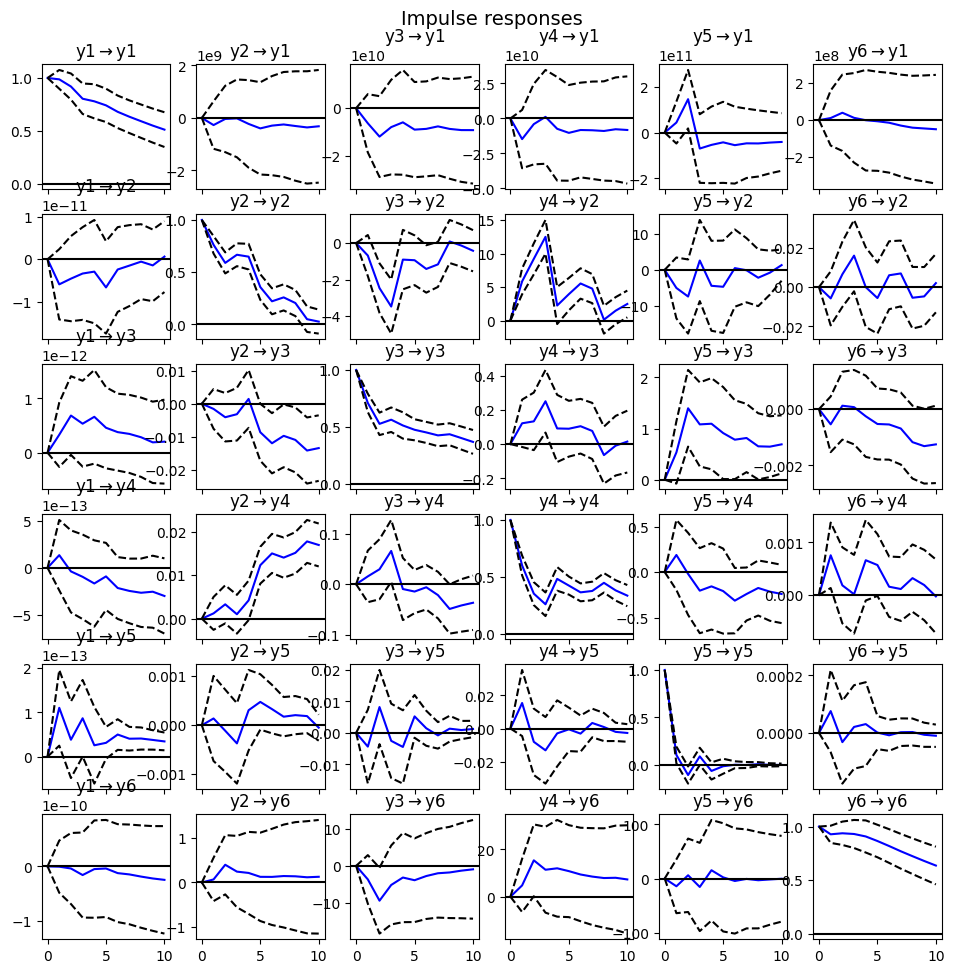

In [45]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('../data/cleaned_global_economic_indicators.csv')

# Select the relevant variables
variables = ['Currency Exchange Rate', 'GDP', 'Inflation Rate', 'Real Interest Rate', 'Trade Balance', 'Unemployment Rate']
data = data[variables]

# Check for stationarity and take first difference if necessary
for var in variables:
    adf_result = adfuller(data[var])
    if adf_result[1] > 0.05:
        data[var] = data[var].diff().dropna()

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)

# Apply PCA
pca = PCA()
data_pca = pca.fit_transform(data_imputed)

# Create a VAR model instance using the PCA components
var_model = VAR(data_pca)

# Determine the optimal lag order using AIC
lag_order_selection = var_model.select_order(maxlags=10)
optimal_lag_order = lag_order_selection.selected_orders['aic']
print(f"Optimal lag order (AIC): {optimal_lag_order}")

# Fit the VAR model with the optimal lag order
fitted_model = var_model.fit(optimal_lag_order)

# Perform Granger Causality Tests
for var1 in range(data_pca.shape[1]):
    for var2 in range(data_pca.shape[1]):
        if var1 != var2:
            granger_result = fitted_model.test_causality(var1, [var2], kind='f')
            print(f"Granger Causality Test: PC{var2} -> PC{var1}")
            print(granger_result)

# Impulse Response Analysis
impulse_response = fitted_model.irf(10)  # Impulse response for 10 periods
impulse_response.plot()

# Forecast Error Variance Decomposition
fevd = fitted_model.fevd(10)  # Forecast error variance decomposition for 10 periods
print(fevd.summary())

Correlation Matrix:
                        Currency Exchange Rate       GDP  Inflation Rate  \
Currency Exchange Rate                1.000000 -0.099852       -0.035341   
GDP                                  -0.099852  1.000000       -0.074880   
Inflation Rate                       -0.035341 -0.074880        1.000000   
Real Interest Rate                   -0.023813 -0.085987        0.458066   
Trade Balance                         0.073559 -0.224236       -0.123989   
Unemployment Rate                    -0.013933 -0.065448        0.018902   
GDP Growth Rate                       0.016633  0.038745       -0.033326   

                        Real Interest Rate  Trade Balance  Unemployment Rate  \
Currency Exchange Rate           -0.023813       0.073559          -0.013933   
GDP                              -0.085987      -0.224236          -0.065448   
Inflation Rate                    0.458066      -0.123989           0.018902   
Real Interest Rate                1.000000      -0.

<Figure size 1000x800 with 0 Axes>

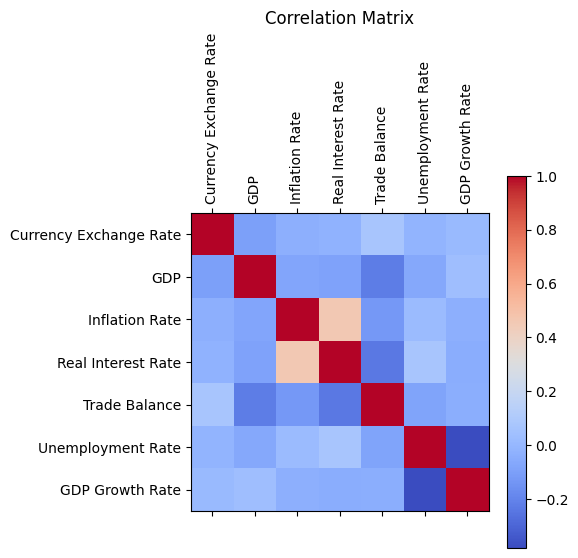

In [48]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('../data/cleaned_global_economic_indicators.csv')

# Select the relevant variables
variables = ['Currency Exchange Rate', 'GDP', 'Inflation Rate', 'Real Interest Rate', 'Trade Balance', 'Unemployment Rate']
data = data[variables]


# Check for stationarity and take first difference if necessary
for var in variables:
    adf_result = adfuller(data[var])
    if adf_result[1] > 0.05:
        data[var] = data[var].diff().dropna()

# Calculate GDP growth rates
data['GDP Growth Rate'] = data['GDP'].pct_change()

# Scale the data (optional)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert NumPy array to DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=variables + ['GDP Growth Rate'])

# Correlation analysis
corr_matrix = data_scaled_df.corr()
print("Correlation Matrix:")
print(corr_matrix)

# Visualize correlations
plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, cmap='coolwarm')
plt.xticks(range(len(variables) + 1), variables + ['GDP Growth Rate'], rotation=90)
plt.yticks(range(len(variables) + 1), variables + ['GDP Growth Rate'])
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

Mean Squared Error (MSE) for GDP: 4.28929126175052e+25


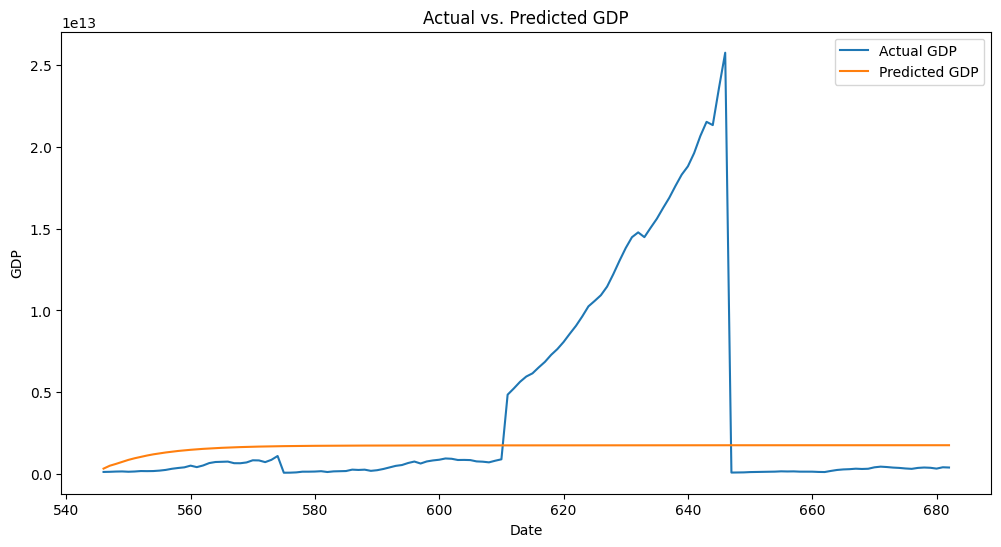

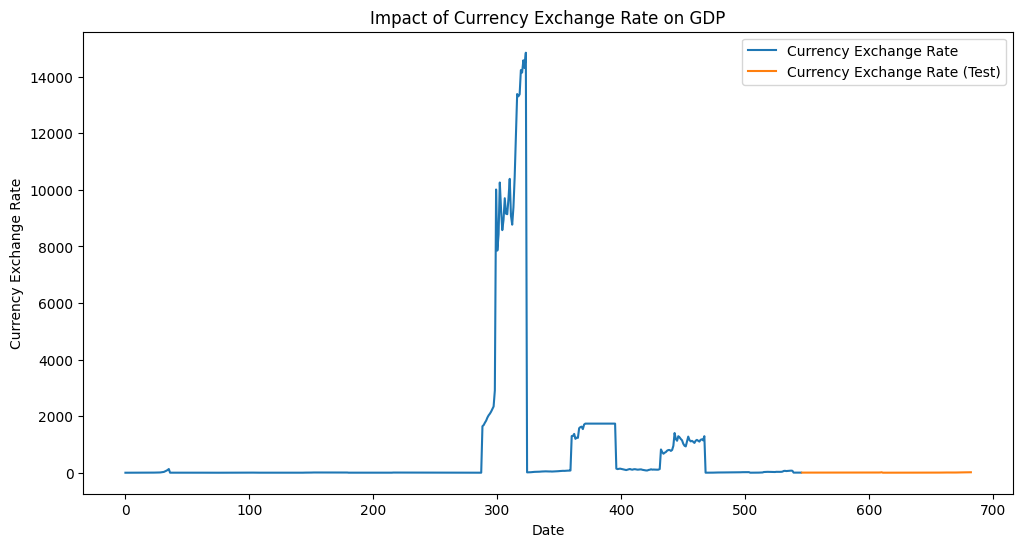

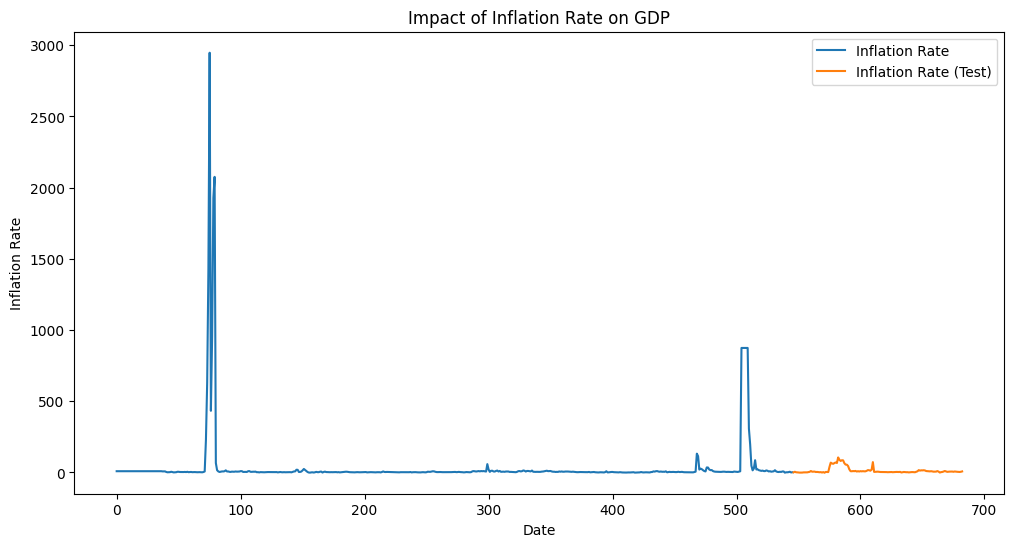

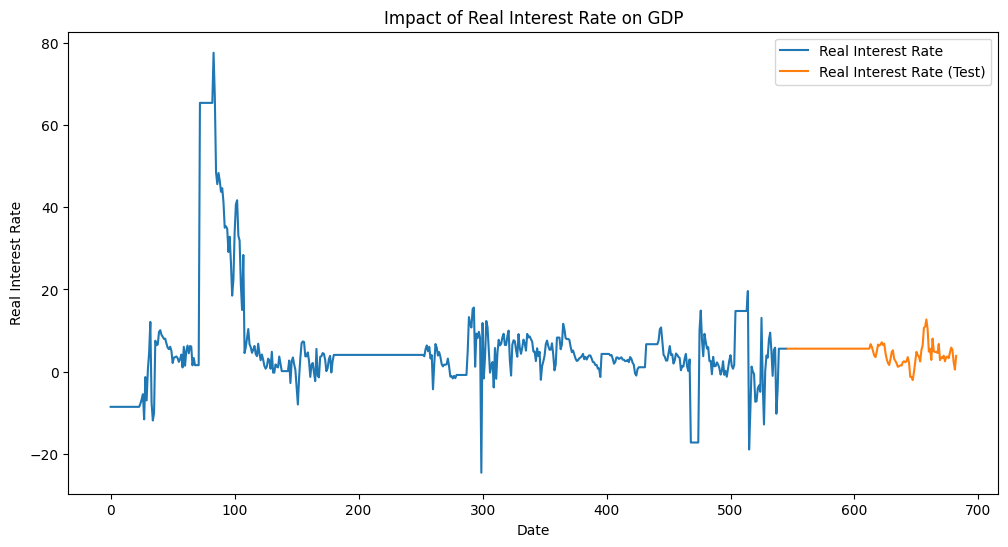

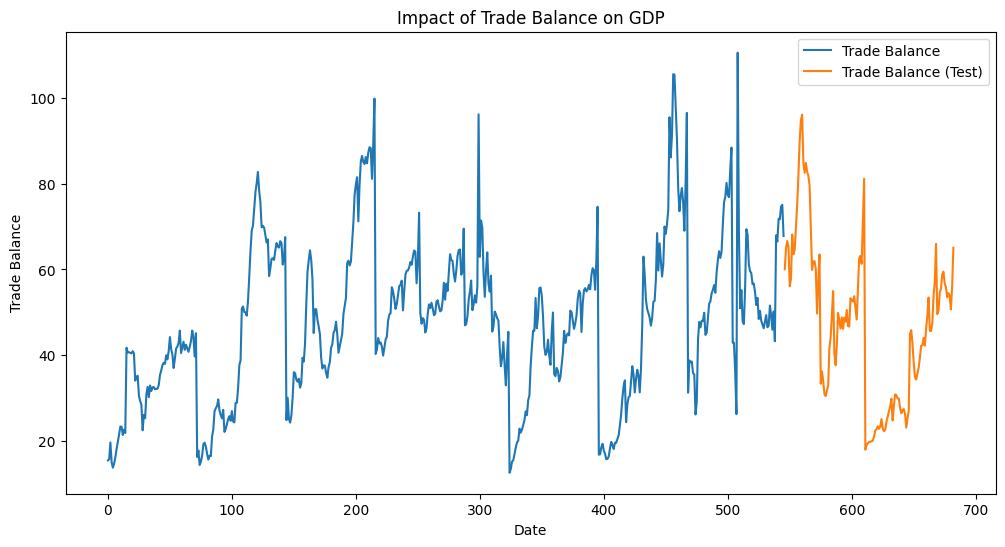

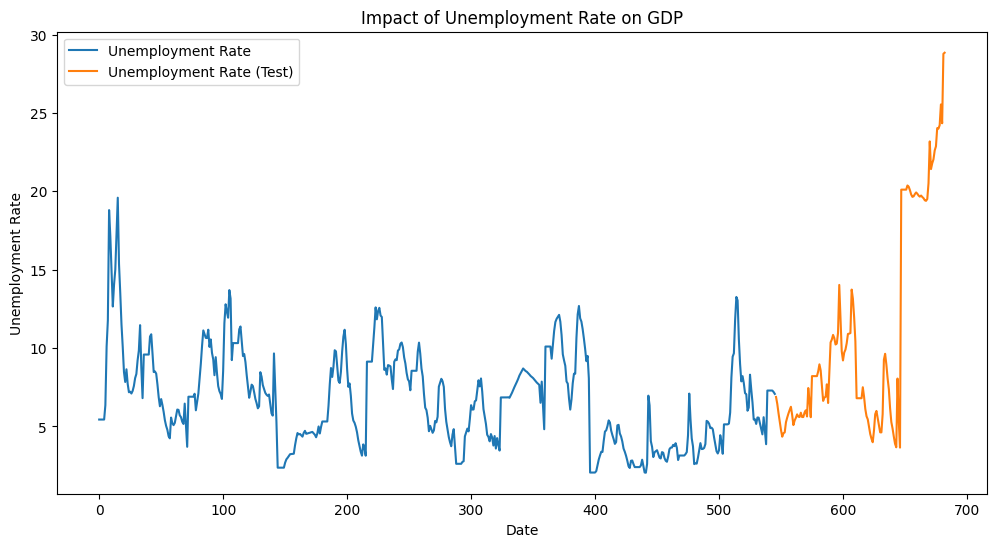

In [52]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('../data/cleaned_global_economic_indicators.csv')

# Select the relevant variables
variables = ['Currency Exchange Rate', 'GDP', 'Inflation Rate', 'Real Interest Rate', 'Trade Balance', 'Unemployment Rate']
data = data[variables]

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Fit the VAR model on the training set
model = VAR(train_data)
order_selection = model.select_order(maxlags=10)
optimal_order = order_selection.selected_orders['aic']
model_fitted = model.fit(optimal_order)

# Make predictions on the test set
predictions = model_fitted.forecast(model_fitted.endog[-optimal_order:], steps=len(test_data))

# Calculate evaluation metrics
mse = mean_squared_error(test_data['GDP'], predictions[:, variables.index('GDP')])
print(f"Mean Squared Error (MSE) for GDP: {mse}")

# Visualize the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['GDP'], label='Actual GDP')
plt.plot(test_data.index, predictions[:, variables.index('GDP')], label='Predicted GDP')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Actual vs. Predicted GDP')
plt.legend()
plt.show()

# Visualize the impact of other variables on GDP
for var in variables:
    if var != 'GDP':
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data[var], label=var)
        plt.plot(test_data.index, test_data[var], label=f'{var} (Test)')
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.title(f'Impact of {var} on GDP')
        plt.legend()
        plt.show()